In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Download Word Vector Library
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
doc = nlp("dog cat banana kem")

for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

dog Vector: True OOV: False
cat Vector: True OOV: False
banana Vector: True OOV: False
kem Vector: False OOV: True


In [6]:
doc[0].vector.shape

(300,)

In [7]:
base_token = nlp("bread")
base_token.vector.shape

(300,)

In [8]:
doc = nlp("bread sandwich burger car tiger human wheat")

for token in doc:
    print(f"{token.text} <-> {base_token.text}:", token.similarity(base_token))

bread <-> bread: 1.0
sandwich <-> bread: 0.6341067010130894
burger <-> bread: 0.47520687769584247
car <-> bread: 0.06451533308853552
tiger <-> bread: 0.04764611675903374
human <-> bread: 0.2151154210812192
wheat <-> bread: 0.6150360888607199


In [9]:
def print_similarity(base_word, words_to_compare):
    base_token = nlp(base_word)
    doc = nlp(words_to_compare)
    for token in doc:
        print(f"{token.text} <-> {base_token.text}: ", token.similarity(base_token))

In [10]:
print_similarity("iphone", "apple samsung iphone dog kitten")

apple <-> iphone:  0.4387907401919904
samsung <-> iphone:  0.670859081425417
iphone <-> iphone:  1.0
dog <-> iphone:  0.08211864228011527
kitten <-> iphone:  0.10222317834969896


In [11]:
king = nlp.vocab["king"].vector
man = nlp.vocab["man"].vector
woman = nlp.vocab["woman"].vector
queen = nlp.vocab["queen"].vector

result = king - man + woman

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([result], [queen])


array([[0.61780137]], dtype=float32)

# Text Classification Using Spacy Word Vector


# Problem Statement
- Fake news refers to misinformation or disinformation in the country which is spread through word of mouth and more recently through digital communication such as What's app messages, social media posts, etc.

- Fake news spreads faster than real news and creates problems and fear among groups and in society.

- We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is Real or Fake Message.

- We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.



In [13]:
import pandas as pd

#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_csv("Fake_Real_Data.csv")

#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(9900, 2)


Text label
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake
1  U.S. conservative leader optimistic of common ...  Real
2  Trump proposes U.S. tax overhaul, stirs concer...  Real
3   Court Forces Ohio To Allow Millions Of Illega...  Fake
4  Democrats say Trump agrees to work on immigrat...  Real

In [14]:
#check the distribution of labels 
df['label'].value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [15]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})

#check the results with top 5 rows
df.head(5)

Text label  label_num
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake          0
1  U.S. conservative leader optimistic of common ...  Real          1
2  Trump proposes U.S. tax overhaul, stirs concer...  Real          1
3   Court Forces Ohio To Allow Millions Of Illega...  Fake          0
4  Democrats say Trump agrees to work on immigrat...  Real          1

## Get spacy word vectors and store them in a pandas dataframe

In [16]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [17]:
#This will take some time(nearly 15 minutes)
df['vector'] = df['Text'].apply(lambda text: nlp(text).vector)  

In [18]:
df.head()

Text label  label_num  \
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake          0   
1  U.S. conservative leader optimistic of common ...  Real          1   
2  Trump proposes U.S. tax overhaul, stirs concer...  Real          1   
3   Court Forces Ohio To Allow Millions Of Illega...  Fake          0   
4  Democrats say Trump agrees to work on immigrat...  Real          1   

                                              vector  
0  [-0.6759837, 1.4263071, -2.318466, -0.451093, ...  
1  [-1.8355803, 1.3101058, -2.4919677, 1.0268308,...  
2  [-1.9851209, 0.14389805, -2.4221718, 0.9133005...  
3  [-2.7812982, -0.16120885, -1.609772, 1.3624227...  
4  [-2.2010763, 0.9961637, -2.4088492, 1.128273, ...

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022
)

In [20]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

In [23]:
from sklearn.metrics import classification_report

In [24]:
y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1024
           1       0.94      0.95      0.94       956

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980



In [25]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1024
           1       0.99      0.99      0.99       956

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



# Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

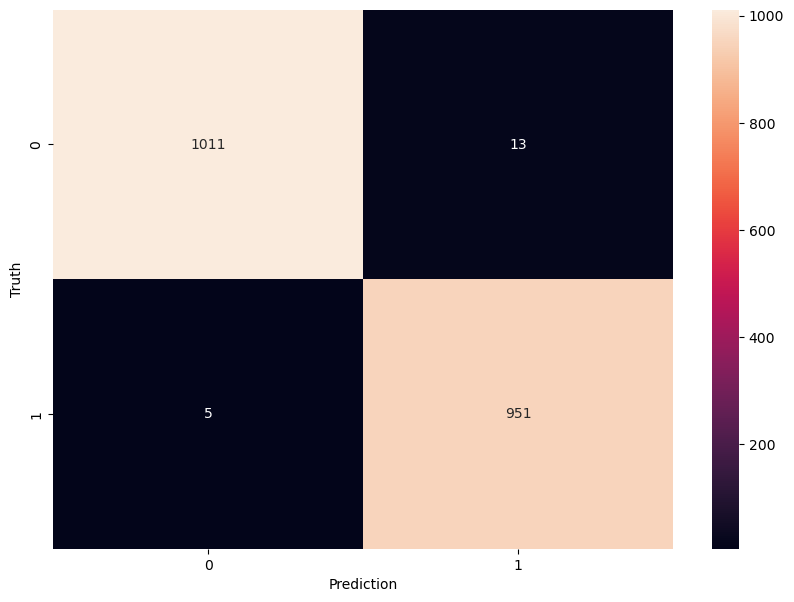

In [26]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Key Takeaways
- KNN model which didn't perform well in the vectorization techniques like Bag of words, and TF-IDF due to very high dimensional vector space, performed really well with glove vectors due to only 300-dimensional vectors and very good embeddings(similar and related words have almost similar embeddings) for the given text data.

- MultinomialNB model performed decently well but did not come into the top list because in the 300-dimensional vectors we also have the negative values present. The Naive Bayes model does not fit the data if there are negative values. So, to overcome this shortcoming, we have used the Min-Max scaler to bring down all the values between 0 to 1. In this process, there will be a possibility of variance and information loss among the data. But anyhow we got a decent recall and f1 scores.

# Exercise 

In [27]:
#import pandas library
import pandas as pd


#read the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('news_dataset.json')

#print the shape of data
print(df.shape)

#print the top5 rows
df.head()

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was Victimized' In Newly Released Videos “That’s my self-torture, I guess you could say. Yes, she was victimized. Yes, I was victimized, to myself.”",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Million On A New NFL Stadium Billionaire Sheldon Adelson wants the stadium to lure the Oakland Raiders to Vegas.,SPORTS
3,This Richard Sherman Interception Literally Shook The World Richard Sherman is good at football.,SPORTS
4,7 Things That Could Totally Kill Weed Legalization's Buzz,BUSINESS


In [28]:
#check the distribution of labels 
df['category'].value_counts()


CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

In [29]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['category'].map({'CRIME': 0, 'SPORTS': 1, 'BUSINESS': 2})


#check the results with top 5 rows
df.head(5) 

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was Victimized' In Newly Released Videos “That’s my self-torture, I guess you could say. Yes, she was victimized. Yes, I was victimized, to myself.”",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Million On A New NFL Stadium Billionaire Sheldon Adelson wants the stadium to lure the Oakland Raiders to Vegas.,SPORTS,1
3,This Richard Sherman Interception Literally Shook The World Richard Sherman is good at football.,SPORTS,1
4,7 Things That Could Totally Kill Weed Legalization's Buzz,BUSINESS,2


# Preprocess the text

In [30]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation


def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [31]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]

df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(text))

In [32]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was Victimized' In Newly Released Videos “That’s my self-torture, I guess you could say. Yes, she was victimized. Yes, I was victimized, to myself.”",CRIME,0,Larry Nassar blame victim say victimize newly release Videos self torture guess yes victimize yes victimize
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Million On A New NFL Stadium Billionaire Sheldon Adelson wants the stadium to lure the Oakland Raiders to Vegas.,SPORTS,1,vegas taxpayer spend Record $ 750 million New NFL Stadium Billionaire Sheldon Adelson want stadium lure Oakland Raiders Vegas
3,This Richard Sherman Interception Literally Shook The World Richard Sherman is good at football.,SPORTS,1,Richard Sherman Interception literally shake World Richard Sherman good football
4,7 Things That Could Totally Kill Weed Legalization's Buzz,BUSINESS,2,7 thing totally kill Weed Legalization Buzz


# Get the spacy embeddings for each preprocessed text

In [33]:
#create a new column "vector" that store the vector representation of each pre-processed text

df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector) 

In [34]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was Victimized' In Newly Released Videos “That’s my self-torture, I guess you could say. Yes, she was victimized. Yes, I was victimized, to myself.”",CRIME,0,Larry Nassar blame victim say victimize newly release Videos self torture guess yes victimize yes victimize,"[-0.5585511, -0.29323253, -0.9253956, 0.18938938, 1.0181136, 1.7050675, 0.700774, 2.2029855, -1.7906338, -0.5034125, 1.6184038, 0.61051875, -1.3079705, 0.584547, 0.63700706, -0.8729482, 1.00014, -1.4759021, 0.17712572, 0.61367625, -0.29666373, 0.7998125, -0.03366186, -1.3914751, 0.02639747, -0.29605618, 0.82793623, 0.047224388, -0.18659225, 0.61112875, 0.5447923, 0.70491487, -0.23620602, 1.504215, -0.65176713, -0.487085, -0.6281269, -0.86626047, 1.6398525, 1.2386812, -2.010722, -0.7159607, 0.4391331, 1.1089885, -0.70660996, -0.7859553, 0.13826066, -2.4608564, -0.25043505, 1.6539725, -0.23573613, 0.36592993, 1.5811756, -2.9950502, -1.1908113, 0.8907906, 0.65194976, 0.7145287, 0.68849564, 1.0460285, 1.8116534, 1.0965936, -1.250417, 0.20302758, 0.5407982, 0.38588813, -1.5728655, -2.7015777, 0.339288, 2.1353512, 0.9090059, 0.12964064, -0.61614573, -0.06784938, -0.8233696, 0.14782315, -0.6123628, 1.7351547, -0.5217984, -0.37534034, -1.4330438, 0.3223193, 1.2905962, -1.2963616, 1.3422588, 0.038690086, -1.3175113, -2.302355, -0.10772556, -0.11250802, 1.1555063, 0.10283564, 0.9505744, -1.5492725, 0.55068505, -0.10365503, 0.2898944, -0.71483684, -0.375995, 0.17064688, ...]"
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628383, 0.42504, -0.13838503, -0.44098833, 3.8327768, 0.641905, 0.972555, 0.6683717, -2.2062018, -1.6571584, 2.9138632, 2.5894017, 0.6101584, 1.1103166, -3.0444677, 1.0227767, -0.11123816, -1.7140951, 1.3778273, -0.89661336, -1.8031917, -1.038225, -1.5874633, -1.5395201, -1.3345093, 2.1686168, 0.60875165, 0.80572826, 0.9278067, 0.33269504, -2.2626534, -0.9940017, -2.2284973, 0.4636167, 1.8241366, -0.36455998, 0.5105666, -0.8698883, -0.14310837, 2.3488998, 4.8127046, -0.880815, 0.6536867, -1.2661667, -1.1948484, -0.49314496, 0.16861664, 0.22341321, 2.6842663, 0.057091713, -0.79655164, -0.56888497, 0.20225835, 1.30548, -1.8032084, 0.105159976, 2.246005, -1.7071418, -2.4748666, -1.69845, 0.35910833, 2.6172817, 0.6100678, -1.2362918, -2.419785, 0.43905005, -0.5966516, 1.1342416, 1.7294234, -1.0342851, 1.0438567, -0.024620017, 0.5699333, 0.047905166, 0.32280335, -1.5771685, 0.35675335, -1.8087851, 1.1774917, 0.42552665, -0.7921517, 2.3062985, 0.18866332, 1.4582716, -0.10767501, -1.4011253, 0.1469133, 1.6270666, 0.5804499, -0.27043164, -1.9466467, -0.30034, 0.050761778, -0.043658335, -0.5858733, 0.90608835, -0.4946333, ...]"
2,Vegas Taxpayers Could Spend A Record $750 Million On A New NFL Stadium Billionaire Sheldon Adelson wants the stadium to lure the Oakland Raiders to Vegas.,SPORTS,1,vegas taxpayer spend Record $ 750 million New NFL Stadium Billionaire Sheldon Adelson want stadium lure Oakland Raiders Vegas,"[-1.9413117, 0.121578515, -3.2996283, 1.5116504, 0.36436155, 0.43181676, 1.6462998, 1.5379994, 1.0370415, 0.25707474, -0.77702385, -2.0690556, -0.37653193, 0.5449878, -2.5801492, 0.11808556, -0.29327288, 0.13370372, -1.4877185, 0.41894746, 1.4319595, 1.2323205, 0.06792742, 0.689866, 1.4557734, 0.31966156, -0.79432416, -0.55384547, 1.3218514, -1.1802721, -0.92366046, 2.7314048, 0.28461576, -2.167781, -0.022811018, -0.18841058, 1.6734202, 0.8589379, -0.5356736, 2.0056517, -1.785386, 0.928444, 0.11849282, 3.4988813, -3.739638, 0.27993155, -0.48731688, 0.29117104, 2.2731783, -0.26231003, 0.33532196, 1.3884683, -1.457856, -1.1441206, -1.0041952, 0.660679, -0.41579524, 0.33461976, -0.39271438, 0.24677949, 0.14961107, 1.3597069, 1.4692721, 1.0121609, 3.10905, -0.18928824, -1.431302, 1.7346265, -0.5101342, 1.3431889, -0.47287053, -0.6805026, -0.07728816, -0.2830911, 0.47085726, 1.27539

# Train Test Split

In [35]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

### Reshape the X_train and X_test so as to fit for models



In [36]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (6000,)
Shape of X_test before reshaping:  (1500,)
Shape of X_train after reshaping:  (6000, 300)
Shape of X_test after reshaping:  (1500, 300)


# Attempt 1:

- use spacy glove embeddings for text vectorization.

- use Decision Tree as the classifier.

- print the classification report.

In [37]:
from sklearn.tree import DecisionTreeClassifier


#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       500
           1       0.71      0.71      0.71       500
           2       0.74      0.73      0.73       500

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500



# Attempt 2:

- use spacy glove embeddings for text vectorization.
- use MultinomialNB as the classifier after applying the MinMaxscaler.
- print the classification report.

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()                                         
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object 
clf = MultinomialNB()

#2. fit with all_train_embeddings and y_train
clf.fit(scaled_train_embed , y_train) 


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(scaled_test_embed)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.85      0.77      0.81       500
           2       0.80      0.83      0.82       500

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



# Attempt 3:

- use spacy glove embeddings for text vectorization.
- use KNeighborsClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [39]:
from  sklearn.neighbors import KNeighborsClassifier


#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       500
           1       0.92      0.81      0.86       500
           2       0.88      0.87      0.88       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



# Attempt 4:

- use spacy glove embeddings for text vectorization.
- use RandomForestClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [40]:
from sklearn.ensemble import RandomForestClassifier


#1. creating a Random Forest model object
clf = RandomForestClassifier()


#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       500
           1       0.92      0.83      0.87       500
           2       0.86      0.90      0.88       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



# Attempt 5:

- use spacy glove embeddings for text vectorization.
- use GradientBoostingClassifier as the classifier after applying the MinMaxscaler.
- print the classification report.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier


#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       500
           1       0.91      0.87      0.89       500
           2       0.88      0.92      0.90       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



## Print the confusion Matrix with the best model got

Text(95.72222222222221, 0.5, 'Truth')

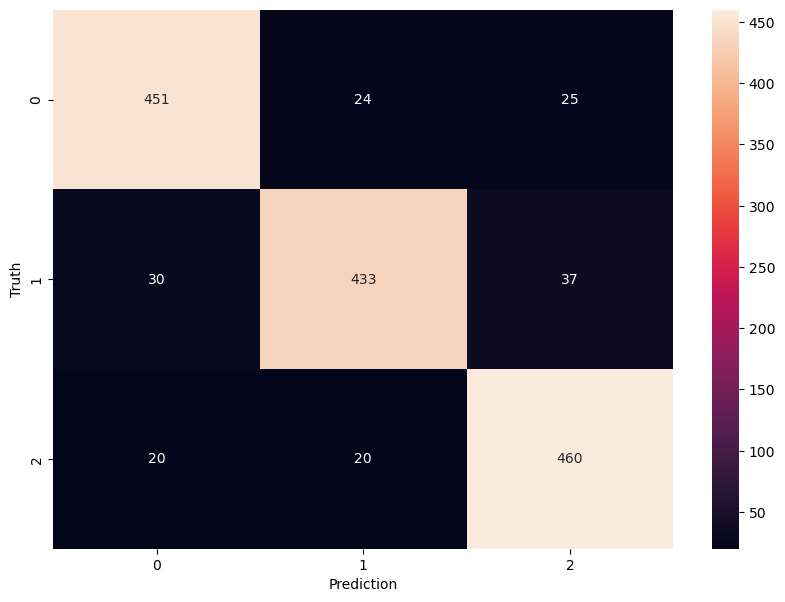

In [42]:
#finally print the confusion matrix for the best model: GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# END